In [1]:
'''
Aim: prepare panels of figure 2 in the manuscript
Date: Sep/2023
Author: Yike Xie
'''

'\nAim: prepare panels of figure 2 in the manuscript\nDate: Sep/2023\nAuthor: Yike Xie\n'

optical features vs gene expression has been done in figure 2 [spectra_norm vs gene exp]

In [2]:
import os
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

import scanpy as sc
import pickle

In [3]:
def sig_dataset(feas_fn, data_fn):
    print('load features')
    with open(feas_fn, 'rb') as f:
        features = pd.read_pickle(f)
    
    print('load dataset')
    adata = sc.read_h5ad(data_fn)
    sc.pp.normalize_total(adata, target_sum=1e6)

    print('filter genes')
    sc.pp.filter_genes(adata, min_cells=10)

    print('Add features to adata')
    for col in features.columns:
        adata.obs[col] = features.loc[adata.obs_names][col]

    return adata

In [4]:
# load dataset
feas_fn = '/home/yike/phd/cancer_cells_img_seq/figures/combine_features.pkl'
data_fn = '/home/yike/phd/cancer_cells_img_seq/data/combine_gene.h5ad'
adata = sig_dataset(feas_fn, data_fn)

# add average optical intensity to adata
df = pd.DataFrame(index=adata.obs_names, columns=adata.obs['wavelengths'].iloc[0])
for i in df.index:
    df.loc[i] = adata.obs['spectra'].loc[i] / adata.obs['area'].loc[i]
    
for col in df.columns:
    adata.obs['{}_{}'.format(col[0], col[1])] = df.loc[adata.obs_names][col]

save_figures = '/home/yike/phd/cancer_cells_img_seq/docs/hyperspectral_sequencing_ewa/figures/new_batch/Figure2/'

load features
load dataset
filter genes
Add features to adata


/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


In [85]:
## load unlogged adata
adata_nonlog = sc.read_h5ad('/home/yike/phd/cancer_cells_img_seq/data/combine_gene.h5ad')
adata_nonlog.var['mt'] = adata_nonlog.var_names.str.startswith('MT-')
adata_nonlog.var['rp'] = adata_nonlog.var_names.str.startswith(('RPS', 'RPL'))
sc.pp.calculate_qc_metrics(adata_nonlog, qc_vars=['mt', 'rp'], percent_top=None, log1p=False, inplace=True)

## divide live and dead cells according to the fraction o mitochondrial reads
live_cells = adata_nonlog.obs[adata_nonlog.obs['pct_counts_mt'] < 25].index
dead_cells = adata_nonlog.obs[adata_nonlog.obs['pct_counts_mt'] > 25].index

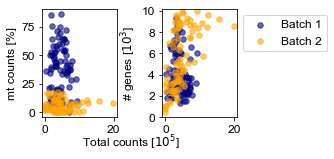

In [102]:
batch2_cells = adata_nonlog.obs_names[adata_nonlog.obs_names.str.contains('3-1')]
batch1_cells = list(set(adata_nonlog.obs_names) - set(batch2_cells))

## plotting
fig, axs = plt.subplots(1, 2, figsize=(3.5, 2), sharex=True)
plt.subplots_adjust(wspace=0.6)
axs[0].scatter(x=adata_nonlog.obs['total_counts'].loc[batch1_cells]/(10**5), 
               y=adata_nonlog.obs['pct_counts_mt'].loc[batch1_cells], 
               c='navy', s=30, alpha=0.6)
axs[0].scatter(x=adata_nonlog.obs['total_counts'].loc[batch2_cells]/(10**5),
               y=adata_nonlog.obs['pct_counts_mt'].loc[batch2_cells] , 
               c='orange', s=30, alpha=0.6)

axs[1].scatter(x=adata_nonlog.obs['total_counts'].loc[batch1_cells]/(10**5), 
               y=adata_nonlog.obs['n_genes_by_counts'].loc[batch1_cells]/(10**3), 
               c='navy', s=30, alpha=0.6, label='Batch 1')
axs[1].scatter(x=adata_nonlog.obs['total_counts'].loc[batch2_cells]/(10**5), 
               y=adata_nonlog.obs['n_genes_by_counts'].loc[batch2_cells]/(10**3), 
               c='orange', s=30, alpha=0.6, label='Batch 2')

axs[0].set_ylabel('mt counts [%]')
axs[1].set_ylabel('# genes [$10^3$]')
axs[1].set_ylim(0, 10.2)
axs[1].set_yticks([0, 2, 4, 6, 8, 10])
axs[1].legend(bbox_to_anchor=[1, 1])

fig.text(0.48, -0.05, 'Total counts [$10^5$]', va='center', ha='center')

save_path = '/home/yike/phd/cancer_cells_img_seq/docs/hyperspectral_sequencing_ewa/figures/new_batch/Figure1/'
fig.savefig(save_path + 'QC3.png', bbox_inches='tight', dpi=300)
fig.savefig(save_path + 'QC3.pdf', bbox_inches='tight', dpi=300)

## PCA on 15 pectras and select components with high variances

In [6]:
if False:
    
    from sklearn.decomposition import PCA
    X = df.values
    pca = PCA()
    X_r = pca.fit(X).transform(X)


    PCA_df = pd.DataFrame(X_r, index=df.index, columns=['PC{}'.format(str(i + 1)) for i in range(15)])
    PCA_df.loc['exp_var'] = pca.explained_variance_ratio_
    PCA_df.to_csv(save_figures + 'PCA_15PC.tsv', sep='\t')
    
    components = pd.DataFrame(pca.components_, index=['PC{}'.format(str(i)) for i in range(1, 16)],
             columns=adata.obs['wavelengths'].iloc[0])
    components.to_csv(save_figures + 'PCA_components.tsv', sep='\t')

In [7]:
## load the analyses results
components = pd.read_csv(save_figures + 'PCA_components.tsv', sep='\t', index_col=0)
X_r = pd.read_csv(save_figures + 'PCA_15PC.tsv', sep='\t')

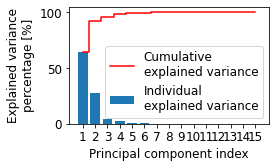

In [12]:
from sklearn.decomposition import PCA
pca = PCA()
X = df.values
pca = PCA()
X_r = pca.fit(X).transform(X)
exp_var = pca.explained_variance_ratio_ * 100
cum_exp_var = np.cumsum(exp_var)

fig, ax = plt.subplots(figsize=[4, 2.5])
rcParams['pdf.fonttype'] = 42
rcParams['font.size'] = 12
ax.bar(range(1, len(exp_var) + 1), exp_var, align='center',
        label='Individual\nexplained variance')
ax.step(range(1, len(exp_var) + 1), cum_exp_var, where='mid',
         label='Cumulative\nexplained variance', color='red')

ax.set_ylabel('Explained variance\npercentage [%]')
ax.set_xlabel('Principal component index')
ax.set_xticks(ticks=range(1, len(exp_var) + 1))
ax.legend(loc='best', fontsize=12)
fig.tight_layout()
# fig.savefig(save_figures + 'PCA_exp_vars.pdf', dpi=300, bbox_inches='tight')
# fig.savefig(save_figures + 'PCA_exp_vars.png', dpi=300, bbox_inches='tight')

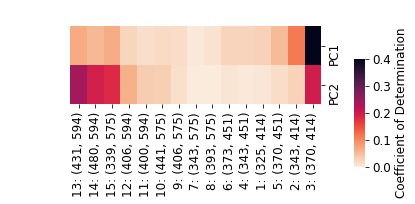

In [35]:
df = pow(components.loc[['PC1', 'PC2']], 2).T.clip(0, 0.4)
idx = df[8:].sort_values('PC2', ascending=False).index.tolist() + df[:8].sort_values('PC1').index.tolist()
wl_index = [i for i in idx]
df = df.loc[wl_index]
index = [['', ' '][list(components.columns).index(i) + 1 < 10] + str(list(components.columns).index(i) + 1) + ': ' + i 
         for i in wl_index]
df.index = index

rcParams['pdf.fonttype'] = 42
g = sns.clustermap(df.T, col_cluster=False, row_cluster=False,
                vmin=0, vmax=0.4, cbar_pos=[1, 0.2, 0.03, 0.5],
                cbar_kws={'label':'Coefficient of Determination'}, cmap='rocket_r',
                figsize=[5, 3])
# g.fig.text(0.1, 0.82, 'Coefficient of Determination')
g.savefig(save_figures + 'square_R.pdf', dpi=150, bbox_inches='tight')

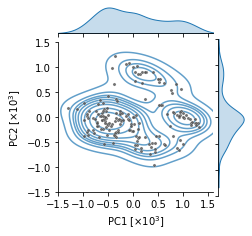

In [29]:
PCA_df = pd.read_csv(save_figures + 'PCA_15PC.tsv', sep='\t', index_col=0)

g = sns.JointGrid(data=PCA_df/10e3, x='PC1', y='PC2')

g.plot_joint(sns.scatterplot, s=10, color=[0.3]*3, alpha=0.8)
g.plot_joint(sns.kdeplot, zorder=-1, alpha=0.7)
g.plot_marginals(sns.kdeplot, cmap='tab10', fill=True, bw_method=0.3)

g.ax_joint.set_aspect('equal', adjustable='box')
g.ax_joint.set(xlabel='PC1 [×$10^3$]', ylabel='PC2 [×$10^3$]',
               xlim=[-1.5, 1.6], ylim=[-1.5, 1.5])
g.ax_joint.set_xticks([-1.5, -1, -0.5, 0, 0.5, 1, 1.5])
g.ax_joint.set_yticks([-1.5, -1, -0.5, 0, 0.5, 1, 1.5])

figure = plt.gcf()
figure.set_size_inches(3, 3)

# plt.savefig(save_figures + 'PCA_2d.pdf', bbox_inches='tight')
# plt.savefig(save_figures + 'PCA_2d.png', bbox_inches='tight')

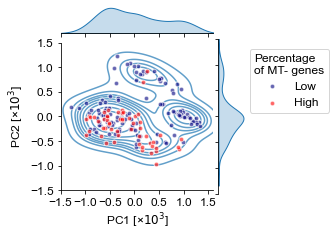

In [30]:
## kde plot with live and dead cells
rcParams['pdf.fonttype'] = 42
rcParams['font.sans-serif'] = "Arial"

PCA_df = pd.read_csv(save_figures + 'PCA_15PC.tsv', sep='\t', index_col=0)
data = PCA_df[:-1][['PC1', 'PC2']]/10e3

g = sns.JointGrid(data=data, x='PC1', y='PC2')

g.plot_joint(sns.scatterplot, s=20, facecolor='none')

g.plot_joint(sns.kdeplot, zorder=-1, alpha=0.7)
g.plot_marginals(sns.kdeplot, cmap='tab10', fill=True, bw_method=0.3)

g.ax_joint.set_aspect('equal', adjustable='box')
g.ax_joint.set(xlabel='PC1 [×$10^3$]', ylabel='PC2 [×$10^3$]',
               xlim=[-1.5, 1.6], ylim=[-1.5, 1.5])
g.ax_joint.set_xticks([-1.5, -1, -0.5, 0, 0.5, 1, 1.5])
g.ax_joint.set_yticks([-1.5, -1, -0.5, 0, 0.5, 1, 1.5])

## add colors to different groups
g.ax_joint.scatter(data.loc[live_cells]['PC1'], data.loc[live_cells]['PC2'], s=20, 
                   facecolor='navy', edgecolor='w', alpha=0.6, 
                   label='Low')

g.ax_joint.scatter(data.loc[dead_cells]['PC1'], data.loc[dead_cells]['PC2'], s=20, 
                   facecolor='red', edgecolor='w', alpha=0.6, 
                   label='High')

g.ax_joint.legend(bbox_to_anchor=[1.2, 1], title='Percentage\nof MT- genes')

figure = plt.gcf()
figure.set_size_inches(3, 3)

figure.savefig(save_figures + 'kde_pct_MT.png', dpi=300, bbox_inches='tight')
figure.savefig(save_figures + 'kde_pct_MT.pdf', dpi=300, bbox_inches='tight')

## I tried to separate these cells into two parts: upper cells and lower cells
# lower_cells = data[data['PC2'] + data['PC1'] * 4/7 < 1/7].index.tolist() # 44.54 % dead cells
# upper_cells = data[data['PC2'] + data['PC1'] * 4/7 > 1/7].index.tolist() # 96.36 % live cells

In [42]:
import cv2
import scipy.stats as stats

## parameters
rcParams['pdf.fonttype'] = 42
xmin, xmax = -1.5, 1.7
ymin, ymax = -1.2, 1.5
kde_thresh = 0.18
PC1_xmin, PC1_xmax, PC1_ymin, PC1_ymax = 400, 650, 150, 350
PC2_xmin, PC2_xmax, PC2_ymin, PC2_ymax = 600, 950, 400, 670

if True:
    ## kde analysis on PC1 and PC2
    X, Y = np.mgrid[xmin:xmax:1000j, ymin:ymax:1000j]
    positions = np.vstack([X.ravel(), Y.ravel()])
    values = np.vstack([data['PC1'], data['PC2']])
    kernel = stats.gaussian_kde(values)
    Z = np.reshape(kernel(positions), X.shape)

    ## create a figure based on kde analysis
    ROI = (np.rot90(Z) > kde_thresh)
    ROI[PC1_ymin: PC1_ymax, PC1_xmin: PC1_xmax] = False
    ROI[PC2_ymin: PC2_ymax, PC2_xmin: PC2_xmax] = False
    
    img = np.zeros((ROI.shape[0], ROI.shape[1], 3))
    for i in range(3):
        img[:, :, i] = ROI
    ## calculate contour coordinates
    imgray = cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(imgray, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = contours[0][:, 0]
    
    xs = contours[:, 0] * (xmax - xmin) / 1000 + xmin
    ys = contours[:, 1] * (ymin - ymax) / 1000 + ymax

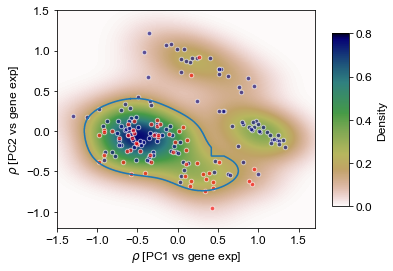

In [43]:
## plot kde analysis
## plot
fig, ax = plt.subplots()

cmap = plt.cm.gist_earth_r
ax.imshow(np.rot90(Z), cmap=cmap, vmin=0, vmax=0.8,
          extent=[xmin, xmax, ymin, ymax])

## show live and dead cells
ax.scatter(data.loc[live_cells]['PC1'], data.loc[live_cells]['PC2'], s=20, 
                   facecolor='navy', edgecolor='w', alpha=0.6)

ax.scatter(data.loc[dead_cells]['PC1'], data.loc[dead_cells]['PC2'], s=20, 
                   facecolor='red', edgecolor='w', alpha=0.6)

## plot the contour
ax.plot(xs.tolist() + [xs[0]], ys.tolist() + [ys[0]])

## lims of x and y axis
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])

## labels of x and y axis
ax.set(xlabel=r'$\rho$ [PC1 vs gene exp]', ylabel=r'$\rho$ [PC2 vs gene exp]')

## colorbar
norm = mpl.colors.Normalize(vmin=0, vmax=0.8)
position = fig.add_axes([0.85, 0.2, 0.04, 0.6])
cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), 
             cax=position, ax=ax, label='Density')

In [45]:
## get the predicted dead cells inside the contour
predict_dead = []
xmin, xmax = -1.5, 1.7
ymin, ymax = -1.2, 1.5

for cell in data.index:
    cell_x = round((data.loc[cell]['PC1'] - xmin) / (xmax - xmin) * 1000)
    cell_y = round((data.loc[cell]['PC2'] - ymax) / (ymin - ymax) * 1000)
    if ROI[cell_y, cell_x]:
        predict_dead.append(cell)
        
## get dead cells out of the predicted dead cells
correct_predict = list(set(predict_dead) & set(dead_cells))

print(f'{round(len(correct_predict) / len(dead_cells) * 100, 2)} % dead cells land in the predicted dead area')

## get dead cells out of the predicted dead cells
correct_predict = list(set(predict_dead) & set(dead_cells))

print(f'{round(len(correct_predict) / len(predict_dead) * 100, 2)} % predicted cells are dead cells')

89.09 % dead cells land in the predicted dead area
44.14 % predicted cells are dead cells


In [49]:
## two blue groups

blue_bright = list(set(predict_dead) & set(live_cells))
blue_dim = list(set(live_cells) - set(blue_bright))

In [75]:
import anndataks

Log2FC = anndataks.compare(adata[blue_bright, ], adata[blue_dim, ], log1p=False, mode='asymp')
Log2FC = Log2FC.rename(columns={'log2_fold_change': 'Log2FC (blue_dim vs blue_bright)',
                                'avg1': 'Avg_exp (blue_bright)',
                                'avg2': 'Avg_exp (blue_dim)',                                
                               })

from statsmodels.stats.multitest import multipletests
adjust_pvalue = multipletests(Log2FC['pvalue'], alpha=0.05, method='fdr_bh')[1] # pvals_corrected Benjamini/Hochberg (non-negative)
Log2FC['pvalue_corrected (Benjamini/Hochberg)'] = adjust_pvalue

Log2FC.to_csv(save_figures + 'DEGs_blue_bright_vs_dim.tsv', sep='\t')

/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categor

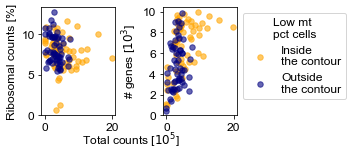

In [109]:
fig, axs = plt.subplots(1, 2, figsize=(3.5, 2), sharex=True)
plt.subplots_adjust(wspace=0.65)
axs[0].scatter(x=adata_nonlog[blue_bright].obs['total_counts']/(10**5), 
               y=adata_nonlog[blue_bright].obs['pct_counts_rp'], 
               c='orange', s=30, alpha=0.6)
axs[0].scatter(x=adata_nonlog[blue_dim].obs['total_counts']/(10**5), 
               y=adata_nonlog[blue_dim].obs['pct_counts_rp'], 
               c='navy', s=30, alpha=0.6)

axs[1].scatter(x=adata_nonlog[blue_bright].obs['total_counts']/(10**5), 
               y=adata_nonlog[blue_bright].obs['n_genes_by_counts']/(10**3), 
               c='orange', s=30, label='Inside\nthe contour', alpha=0.6)
axs[1].scatter(x=adata_nonlog[blue_dim].obs['total_counts']/(10**5), 
               y=adata_nonlog[blue_dim].obs['n_genes_by_counts']/(10**3), 
               c='navy', s=30, label='Outside\nthe contour', alpha=0.6)

axs[0].set_ylabel('Ribosomal counts [%]')
axs[1].set_ylabel('# genes [$10^3$]')
axs[1].set_ylim(0, 10.5)
axs[1].set_yticks([0, 2, 4, 6, 8, 10])
axs[1].legend(title='Low mt\npct cells', bbox_to_anchor=[1, 1])

fig.text(0.48, -0.05, 'Total counts [$10^5$]', va='center', ha='center')

fig.savefig(save_figures + 'QC_blue.png', bbox_inches='tight', dpi=300)
fig.savefig(save_figures + 'QC_blue.pdf', bbox_inches='tight', dpi=300)

In [152]:
adata_nonlog.obs['total_counts [$10^5$]'] = adata_nonlog.obs['total_counts'] / 10**5
adata_nonlog.obs['# genes [$10^3$]'] = adata_nonlog.obs['n_genes_by_counts'] / 10**3

/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categor

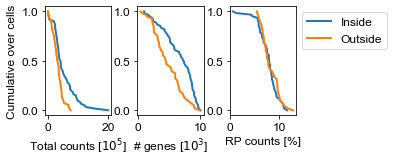

In [159]:
fig, axs = plt.subplots(1, 3, figsize=(4.5, 2))
plt.subplots_adjust(wspace=0.4)

feas =  ['total_counts [$10^5$]', '# genes [$10^3$]', 'pct_counts_rp']
xlabels = ['Total counts [$10^5$]', '# genes [$10^3$]', 'RP counts [%]']

for i, fea, xlabel in zip(range(3), feas, xlabels):
    x1 = np.sort(adata_nonlog[blue_bright].obs[fea])
    y1 = 1 - np.linspace(0, 1, len(blue_bright))

    x2 = np.sort(adata_nonlog[blue_dim].obs[fea])
    y2 = 1 - np.linspace(0, 1, len(blue_dim))
    
    axs[i].plot(x1, y1, label='Inside', lw=2)
    axs[i].plot(x2, y2, label='Outside', lw=2)
    
    axs[i].set_xlabel(xlabel)

axs[0].set_ylabel('Cumulative over cells')
axs[2].legend(bbox_to_anchor=[1, 1])

fig.savefig(save_figures + 'QC_blue2.png', bbox_inches='tight', dpi=300)
fig.savefig(save_figures + 'QC_blue2.pdf', bbox_inches='tight', dpi=300)

In [ ]:
## Examples of cells w or w/o rings
## Small PCA to show the position of these two cells



In [46]:
## data processing
## create four groups

PCA_df = pd.read_csv(save_figures + 'PCA_15PC.tsv', sep='\t', index_col=0)

data = PCA_df.iloc[:-1][['PC1', 'PC2']]/10e3

group1 = data[data['PC2'] > 0.45].index.tolist()
group2 = data[(-0.35 < data['PC2']) &
              (data['PC2'] < 0.45) &
              (0.5 < data['PC1']) &
              (data['PC1'] < 1.5)
             ].index.tolist()

group3 = data[(-0.5 < data['PC2']) &
              (data['PC2'] < 0.45) &
              (-1.3 < data['PC1']) &
              (data['PC1'] < 0.2)
             ].index.tolist()
# (-1.3, -0.5), 1.5, 0.95, 
group4 = [i for i in data[data['PC2'] < 0.4].index if i not in group2 + group3]

data.loc[group1, 'Group'] = 'group1'
data.loc[group2, 'Group'] = 'group2'
data.loc[group3, 'Group'] = 'group3'
data.loc[group4, 'Group'] = 'group4'

## number of cells in four groups
for i in range(1, 5):
    n = (data['Group'] == f'group{str(i)}').sum()
    print(f'group{str(i)}: {str(n)}')

group1: 25
group2: 28
group3: 95
group4: 26


/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categor

Text(0.48, -0.05, 'Total counts [$10^5$]')

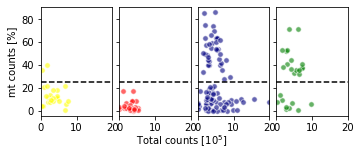

In [86]:
## plot percentage of mitochondrial genes
fig, axs = plt.subplots(1, 4, figsize=(5.5, 2), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.1)

for i, (group, color) in enumerate(zip([group1, group2, group3, group4], ['yellow', 'red', 'navy', 'green'])):
    temp = adata_nonlog[group, :]
    
    axs[i].scatter(x=temp.obs['total_counts']/(10**5), y=temp.obs['pct_counts_mt'], 
                   c=color, edgecolor='white', s=30, alpha=0.6)
    axs[i].axhline(25, ls='--', c='k')
    axs[0].set_xlim(0, 20)
    
axs[0].set_ylabel('mt counts [%]')

fig.text(0.48, -0.05, 'Total counts [$10^5$]', va='center', ha='center')

# save_path = '/home/yike/phd/cancer_cells_img_seq/docs/hyperspectral_sequencing_ewa/figures/new_batch/Figure1/'
# fig.savefig(save_path + 'QC2.png', bbox_inches='tight', dpi=300)
# fig.savefig(save_path + 'QC2.pdf', bbox_inches='tight', dpi=300)

In [9]:
### load the old analyses of batch 1 & batch 2

# feas_fn = '/home/yike/phd/cancer_cells_img_seq/figures/batch_202112/segmentation/background_subtraction/bkg_sub_features.pkl'
data_fn = '/home/yike/phd/cancer_cells_img_seq/data/20220201_NextSeq/gene_filter.h5ad'

old_adata = sc.read_h5ad(data_fn)
old_adata = old_adata[old_adata.obs['doublets'] != 'Yes']
ls = old_adata.obs_names.tolist()
ls.remove('O7_S65')
old_adata = old_adata[ls, :]

fdn = '/home/yike/phd/cancer_cells_img_seq/figures/batch_202112/hyperspectral_images/correlate_features/PCA_gene/'
old_X_r = pd.read_csv(fdn + 'PCA_15PC.tsv', sep='\t')
data = old_X_r[:-1].set_index('cell_name').loc[old_adata.obs_names]
data.index = [j + '_' + i for i, j in zip(old_adata.obs_names, old_adata.obs['batch'])]

old_group1 = data[data['PC1'] > 500].index
old_group2 = data[data['PC1'] < 500].index

/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


In [69]:
## match new groups with old groups

cells1 = set(old_group1) - set(group1 + group2) 

print('live cells in old group 1 but not in new group 1&2:\n')
print(cells1)
print('-----------------------------------------------------')

cells2 = set([i for i in group1 + group2 if '3-1' not in i]) - set(old_group1)

print('live cells in new group 1&2 but not in old group 1:\n')
print(cells2)
print('-----------------------------------------------------')

live cells in old group 1 but not in new group 1&2:

{'1-1_M6_S50', '1-1_N6_S51', '2-1_O11_S117', '1-2_E4_S16', '1-1_O6_S52'}
-----------------------------------------------------
live cells in new group 1&2 but not in old group 1:

set()
-----------------------------------------------------


In [70]:
cells3 = set(old_group2) - set(group3 + group4) 

print('dead cells in old group 2 but not in new group 3&4:\n')
print(cells3)
print('-----------------------------------------------------')

cells4 = set([i for i in group3 + group4 if '3-1' not in i]) - set(old_group2)

print('dead cells in new group 3&4 but not in old group 2:\n')
print(cells4)
print('-----------------------------------------------------')

dead cells in old group 2 but not in new group 3&4:

set()
-----------------------------------------------------
dead cells in new group 3&4 but not in old group 2:

{'1-1_M6_S50', '1-1_N6_S51', '2-1_O11_S117', '1-2_E4_S16', '1-1_O6_S52'}
-----------------------------------------------------


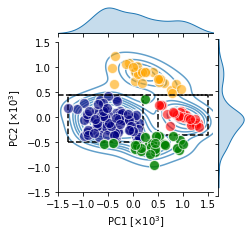

In [47]:
## plotting

# cells = ['1-1_M6_S50', '1-1_N6_S51', '2-1_O11_S117', '1-2_E4_S16', '1-1_O6_S52']
g = sns.JointGrid(data=data, x='PC1', y='PC2')

g.plot_joint(sns.scatterplot, s=100, facecolor='none')

g.plot_joint(sns.kdeplot, zorder=-1, alpha=0.7)
g.plot_marginals(sns.kdeplot, cmap='tab10', fill=True, bw_method=0.3)

g.ax_joint.set_aspect('equal', adjustable='box')
g.ax_joint.set(xlabel='PC1 [×$10^3$]', ylabel='PC2 [×$10^3$]',
               xlim=[-1.5, 1.6], ylim=[-1.5, 1.5])
g.ax_joint.set_xticks([-1.5, -1, -0.5, 0, 0.5, 1, 1.5])
g.ax_joint.set_yticks([-1.5, -1, -0.5, 0, 0.5, 1, 1.5])

# add separting lines
g.ax_joint.axhline(0.45, c='k', lw=1.5, ls='--')

rect1 = plt.Rectangle((0.5, -0.35), 1, 0.8, 
                     edgecolor='k', 
                     fill=False, lw=1.5, ls='--')
g.ax_joint.add_patch(rect1)

rect2 = plt.Rectangle((-1.3, -0.5), 1.5, 0.95, 
                     edgecolor='k', 
                     fill=False, lw=1.5, ls='--')
g.ax_joint.add_patch(rect2)

## add colors to different groups
g.ax_joint.scatter(data.loc[group1]['PC1'], data.loc[group1]['PC2'], s=100, 
                   facecolor='orange', edgecolor='w', alpha=0.6)

g.ax_joint.scatter(data.loc[group2]['PC1'], data.loc[group2]['PC2'], s=100, 
                   facecolor='red', edgecolor='w', alpha=0.6)

g.ax_joint.scatter(data.loc[group3]['PC1'], data.loc[group3]['PC2'], s=100, 
                   facecolor='navy', edgecolor='w', alpha=0.6)

g.ax_joint.scatter(data.loc[group4]['PC1'], data.loc[group4]['PC2'], s=100, 
                   facecolor='green', edgecolor='w', alpha=0.6)

g.ax_joint.scatter(data.loc[group4]['PC1'], data.loc[group4]['PC2'], s=100, 
                   facecolor='green', edgecolor='w', alpha=0.6)

# to show a specific cell

# g.ax_joint.scatter(data.loc[cells]['PC1'], data.loc[cells]['PC2'], s=100, 
#                    facecolor='pink', edgecolor='w')

figure = plt.gcf()
figure.set_size_inches(3, 3)

## save figure
# plt.savefig(save_figures + 'PCA_2d_anno2.pdf', bbox_inches='tight')
# plt.savefig(save_figures + 'PCA_2d_anno2.png', bbox_inches='tight')

### differentially expressed genes between live and dead inside the contour

In [48]:
contour_live = [i for i in predict_dead if i in live_cells]
contour_dead = [i for i in predict_dead if i in dead_cells]

In [49]:
log2fc = pd.Series(np.log2(adata[contour_live,].X.mean(axis=0) + 1) - np.log2(adata[contour_dead,].X.mean(axis=0) + 1),
                   index=adata.var_names)

/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


In [409]:
log2fc.loc[log2fc.index.str.startswith("CASP")].sort_values()

gene_name
CASP2      -0.805313
CASP7       0.544740
CASP8       0.632463
CASP8AP2    1.678617
CASP3       2.099758
CASP6       3.679751
CASP9       3.821890
dtype: float32

/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


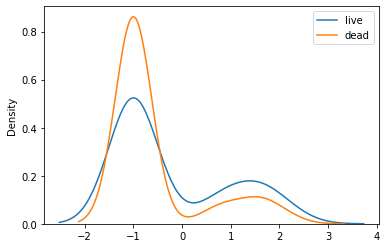

In [421]:
fig, ax = plt.subplots()
sns.kdeplot(np.log10(0.1 + adata[contour_live, 'CASP9'].X[:, 0]), ax=ax, label="live")
sns.kdeplot(np.log10(0.1 + adata[predict_dead, 'CASP9'].X[:, 0]), ax=ax, label="dead")
ax.legend()

/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


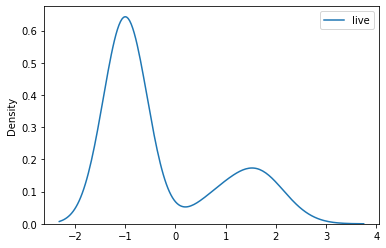

In [422]:
fig, ax = plt.subplots()
sns.kdeplot(np.log10(0.1 + adata[live_cells, 'CASP9'].X[:, 0]), ax=ax, label="live")
sns.kdeplot(np.log10(0.1 + adata[dead_cells, 'CASP9'].X[:, 0]), ax=ax, label="dead")
ax.legend()